In [5]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import pocomc as pc
import mistsim as ms

In [6]:
NBINS = 24

### Load data

['ant_temp', 'freq', 'lst']


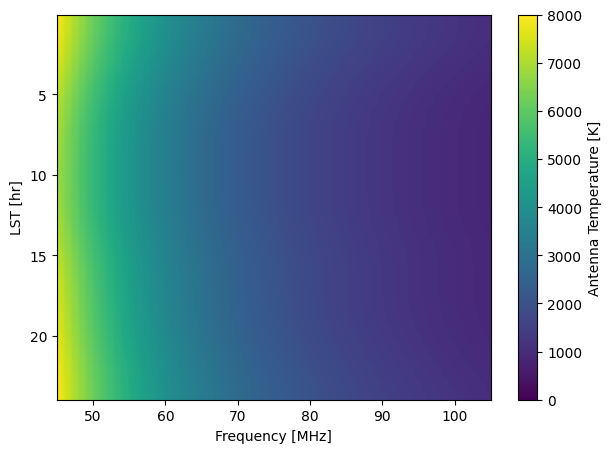

In [7]:
lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
    print_key=True,
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only

plt.figure(figsize=(7,5))
im = plt.imshow(
    temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

### Global signal

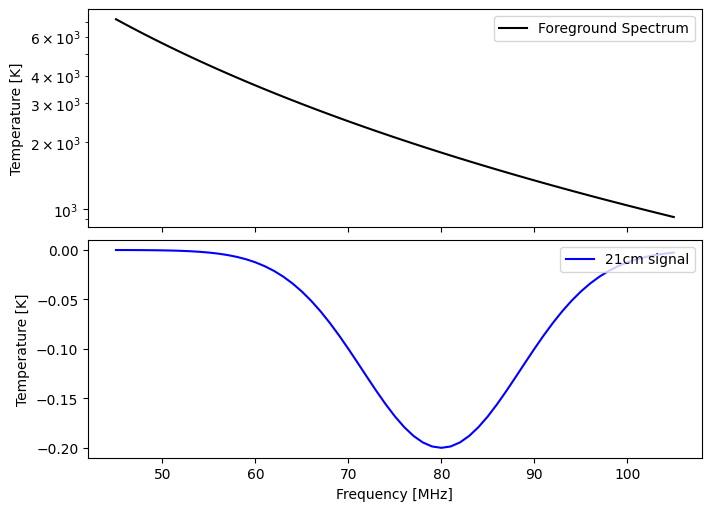

In [8]:
TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
TRUE_T21 = ms.utils.gauss(freq, **TRUE_PARAMS)

fig, axs = plt.subplots(figsize=(7,5), nrows=2, sharex=True, constrained_layout=True)
axs[0].semilogy(freq, fg_mean, label="Foreground Spectrum", c="k")
axs[1].plot(freq, TRUE_T21, label="21cm signal", c="blue")
axs[1].set_xlabel("Frequency [MHz]")
for ax in axs:
    ax.legend(loc="upper right")
plt.setp(axs, ylabel="Temperature [K]")
plt.show()

### Foreground model

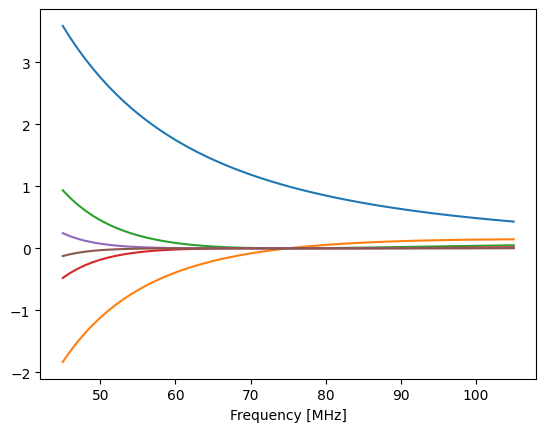

In [9]:
A = ms.utils.design_mat(freq, 6)

plt.figure()
for i in range(A.shape[1]):
    plt.plot(freq, A[:, i])
plt.xlabel("Frequency [MHz]")
plt.show()

### Noise

The noise covariance is taken to be diagonal. We assume systematic uncertainities have been calibrated and are left with radiometer noise. The noise in each frequency channel scales according to the radiometer equation, that is, the standard deviation is proportional to the system temperature and inversly proportional to the root of the integration time.

The first paper took the noise for the 24h avg spectrum to be 3 mK at 75 MHz and we follow that here.

In [10]:
cut = nspec % NBINS
total_temp = temp + TRUE_T21

if cut == 0:
    binned = total_temp.copy()
else:
    binned = total_temp[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)


tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = total_temp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

In [11]:
NFG = [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 7, 4, 5, 5, 5, 4]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i]) for i in range(NBINS)]

### Run sampler

In [12]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler(bounds, lst_bins)

Iter: 61it [07:41,  7.57s/it, calls=25750, beta=1, logZ=-728, ESS=5.01e+3, acc=0.905, steps=1, logP=-722, eff=0.72]           


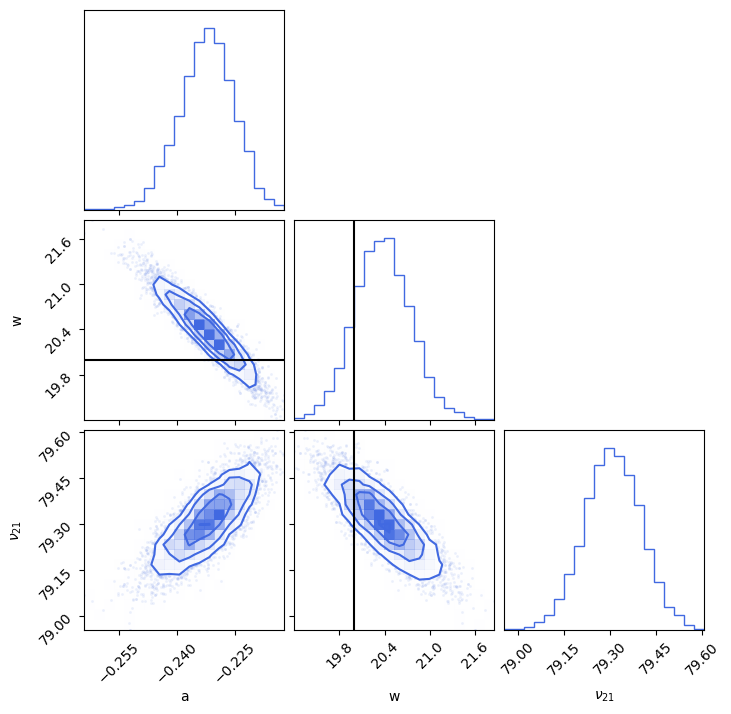

In [13]:
labels = ["a", "w", "$\\nu_{21}$"]
fig = corner.corner(results["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [14]:
estimated_params = results["theta_map"]
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.23227335 20.37732552 79.30940257]
Standard deviation values =  [0.00703996 0.37179063 0.09208855]

[13.89455596  1.85169307  0.87076363]
[4.58430856 1.01488713 7.49927577]


# Chromaticity correction

In [15]:
path = "CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5"
acp = path.replace(".hdf5", "_achromatic_75MHz.hdf5")
acp

'CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains_achromatic_75MHz.hdf5'

In [16]:
path

'CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5'

['ant_temp', 'freq', 'lst']


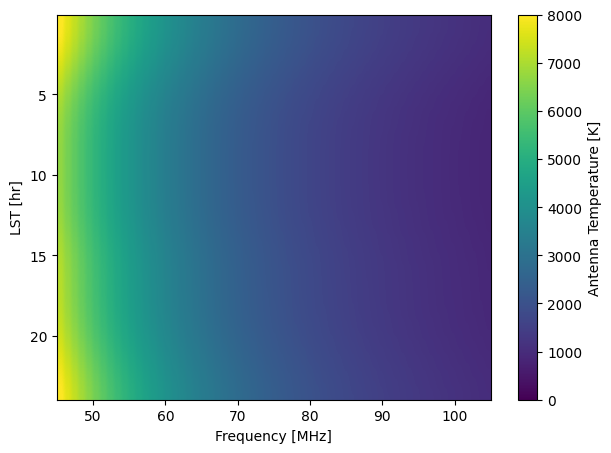

In [17]:
ac_temp = ms.utils.read_hdf5_convolution(f"../simulations/{acp}", print_key=True)[-1]

ac_temp = ac_temp[:, indx]


plt.figure(figsize=(7,5))
im = plt.imshow(
    ac_temp, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0, 8000)
plt.colorbar(label="Antenna Temperature [K]")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

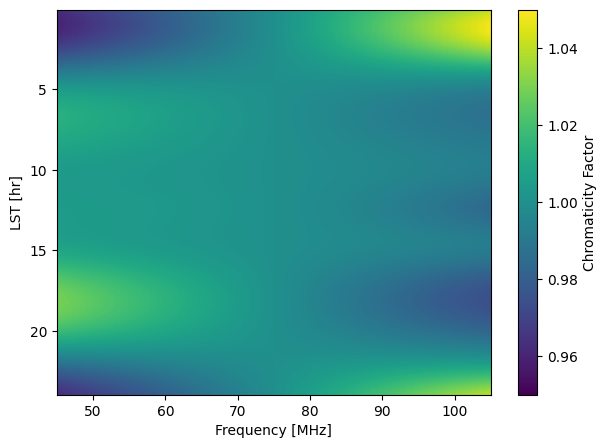

In [18]:
chrom = temp / ac_temp  # chromaticity factor (BF)

plt.figure(figsize=(7,5))
im = plt.imshow(
    chrom, aspect="auto", extent=[freq.min(), freq.max(), lst.max(), lst.min()]
)
im.set_clim(0.95, 1.05)
plt.colorbar(label="Chromaticity Factor")
plt.xlabel("Frequency [MHz]")
plt.ylabel("LST [hr]")
plt.show()

In [19]:
ctemp = (temp+TRUE_T21) / chrom  # = ac temp, the waterfall due to achromatic beam

print(np.allclose(ctemp, ac_temp))
if cut == 0:
    binned = ctemp.copy()
else:
    binned = ctemp[:-cut]
    chrom = chrom[:-cut]
binned = binned.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
chrom_mean = chrom.reshape(nspec//NBINS, NBINS, nfreq).mean(axis=0)
print(chrom_mean.shape)

tint_ratio = (nspec//NBINS) / nspec
noise_75 = 3e-3
t75 = ctemp.mean(axis=0)[freq == 75]
noise, sigma_inv = ms.utils.gen_noise(binned, t75, ref_noise=noise_75, tint_ratio=tint_ratio)

False
(24, 61)


In [20]:
print(noise.shape)
print(sigma_inv.shape)
print(chrom_mean.shape)

(24, 61)
(24, 61)
(24, 61)


In [21]:
NFG = [4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 4, 4, 7, 4, 5, 5, 5, 4]
lst_bins = [ms.lstbin.LSTBin(freq, binned[i]+noise[i], np.diag(sigma_inv[i]), NFG[i], chrom=chrom_mean[i]) for i in range(NBINS)]

In [22]:
bounds = np.array([[-1., 1.], [1., 60.], [45., 105.]])
results = ms.run_sampler(bounds, lst_bins)

Iter: 60it [08:00,  8.01s/it, calls=21500, beta=1, logZ=-736, ESS=4.84e+3, acc=0.922, steps=2, logP=-731, eff=0.72]           


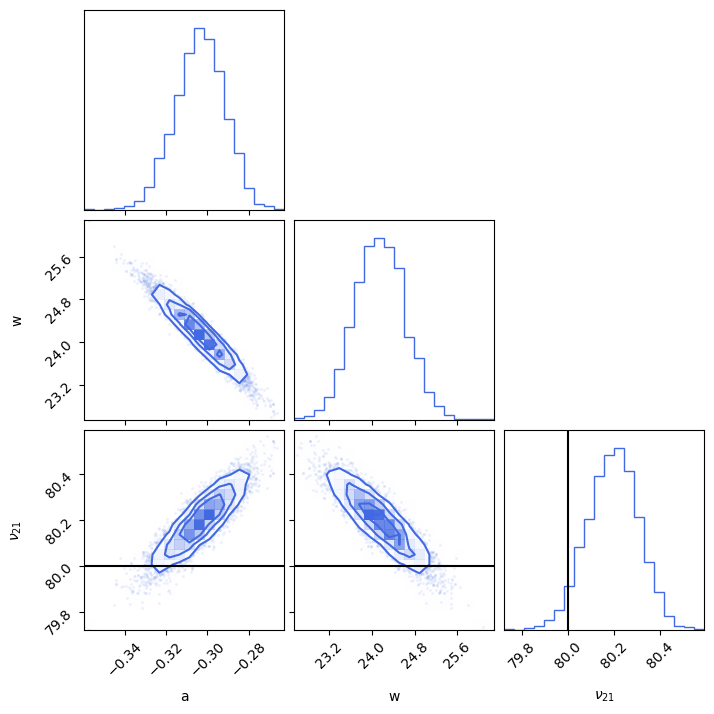

In [23]:
fig = corner.corner(results["samples"], labels=labels, color="royalblue", truths=list(TRUE_PARAMS.values()), truth_color="k")

In [24]:
estimated_params = results["theta_map"]
std_vals = np.std(results['samples'], axis=0)
print('Mean values = ', estimated_params)
print('Standard deviation values = ', std_vals)
print()
print(100 * np.abs(1 - np.array(list(TRUE_PARAMS.values())) /estimated_params))
print(np.abs(estimated_params-np.array(list(TRUE_PARAMS.values())))/std_vals)

Mean values =  [-0.30347829 24.15516154 80.19648711]
Standard deviation values =  [0.01191704 0.46952976 0.11170342]

[34.09742784 17.20196131  0.24500712]
[8.68322407 8.84962341 1.75900708]
